In [1]:
import matplotlib.pyplot as plt
import numpy as np

from iterative_ensemble_smoother.esmda import ESMDA
from iterative_ensemble_smoother.experimental import DistanceESMDA

# 1D Test

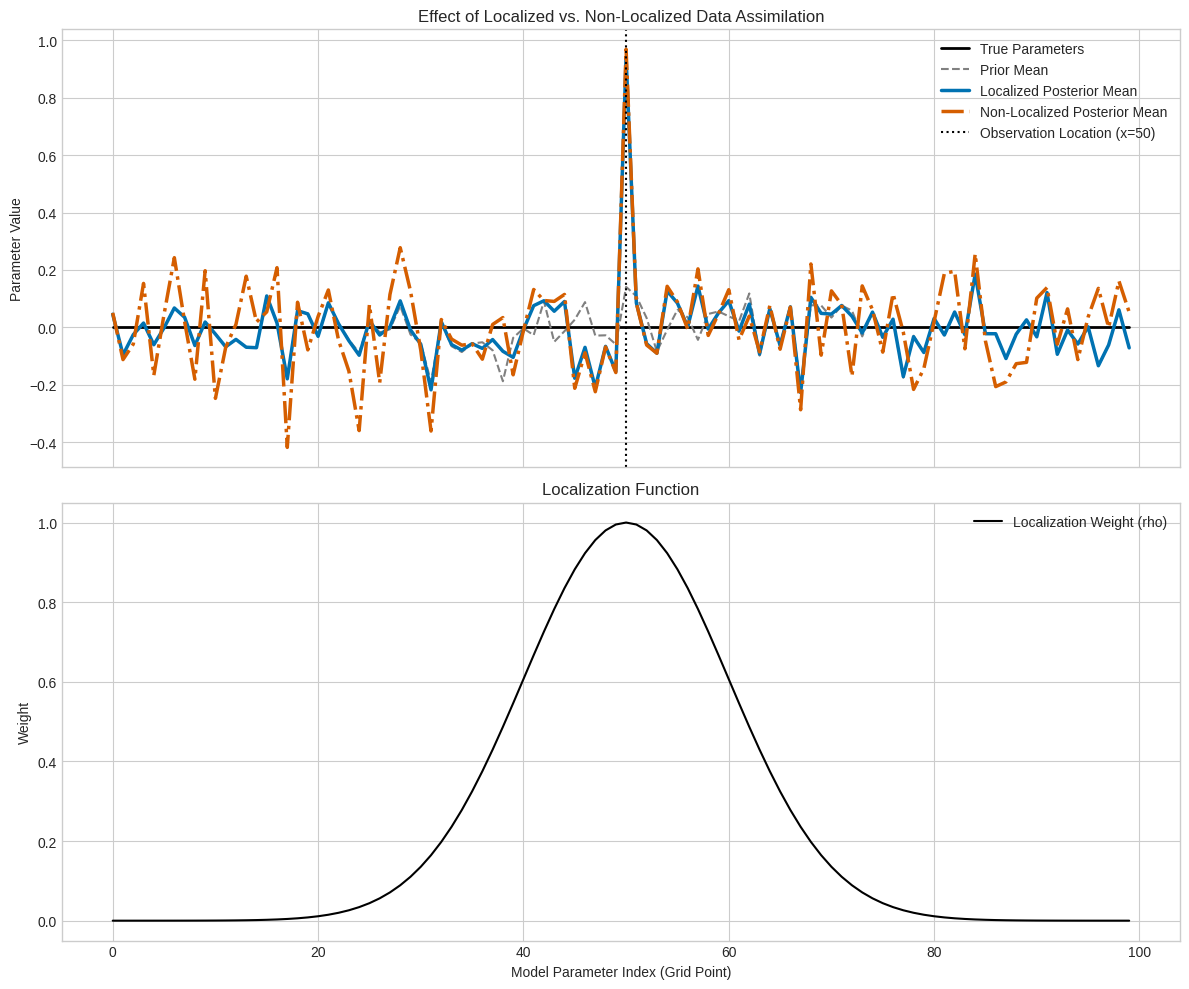

In [2]:
# System properties
N_m = 100  # Number of model parameters (grid points)
N_e = 50  # Ensemble size
j_obs = 50  # Index of the single observation
N_d = 1  # Number of observations

# Assimilation properties
alpha_i = 1  # TODO: Implement multiple iterations
obs_error_var = 0.01  # Variance of observation error
SEED = 42

# Define the "true" model parameters
true_parameters = np.zeros(N_m)

# Define the "true" observation vector (1D)
true_observations = np.array([1.0])

# Observation error covariance `C_D`. Since N_d=1, it's a 1-element vector.
C_D = np.array([obs_error_var])

# --- 2. Generate Initial Ensemble and Predictions ---

# Create initial ensemble of parameters `X` (prior)
# Shape: (N_m, N_e)
rng = np.random.default_rng(SEED)
X_initial = rng.normal(loc=0.0, scale=0.5, size=(N_m, N_e))

# Predict observations `Y` using the identity model `g(x) = x`
# We only observe the state at `j_obs`.
# Shape: (N_d, N_e) -> (1, 50)
Y = X_initial[[j_obs], :]


# --- 3. Construct Localization, Covariance, and Smoother ---

# Localization matrix `rho`
# Shape: (N_m, N_d) -> (100, 1)
localization_radius = 10.0
model_grid = np.arange(N_m)
distances = np.abs(model_grid - j_obs)
# Using a simple Gaussian decay for rho
rho = np.exp(-0.5 * (distances / localization_radius) ** 2).reshape(-1, 1)

smoother = DistanceESMDA(
    covariance=C_D, observations=true_observations, alpha=1, seed=SEED
)
smoother_ESMDA = ESMDA(
    covariance=C_D, observations=true_observations, alpha=1, seed=SEED
)

D = smoother.perturb_observations(ensemble_size=N_e, alpha=alpha_i)

# --- 4. Run Assimilation and Analyze ---

# Run the assimilation
X_posterior = smoother.assimilate(X=X_initial, Y=Y, rho=rho)
X_posterior_ESMDA = smoother_ESMDA.assimilate(X=X_initial, Y=Y)

# Calculate the mean of the prior and posterior ensembles
prior_mean = np.mean(X_initial, axis=1)
posterior_mean = np.mean(X_posterior, axis=1)
posterior_mean_ESMDA = np.mean(X_posterior_ESMDA, axis=1)

# --- 5. Plot the Results ---

plt.style.use("seaborn-v0_8-whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot 1: Ensemble means
# Use a colorblind-safe palette and distinct line styles
# From Paul Tol's color schemes: https://personal.sron.nl/~pault/
color_localized = "#0072B2"  # Blue
color_non_localized = "#D55E00"  # Orange

ax1.plot(
    model_grid,
    true_parameters,
    color="black",
    linestyle="-",
    linewidth=2,
    label="True Parameters",
)
ax1.plot(
    model_grid,
    prior_mean,
    color="gray",
    linestyle="--",
    linewidth=1.5,
    label="Prior Mean",
)
ax1.plot(
    model_grid,
    posterior_mean,
    color=color_localized,
    linestyle="-",
    linewidth=2.5,
    label="Localized Posterior Mean",
)
ax1.plot(
    model_grid,
    posterior_mean_ESMDA,
    color=color_non_localized,
    linestyle="-.",
    linewidth=2.5,
    label="Non-Localized Posterior Mean",
)
ax1.axvline(
    j_obs,
    color="black",
    linestyle=":",
    linewidth=1.5,
    label=f"Observation Location (x={j_obs})",
)

ax1.set_ylabel("Parameter Value")
ax1.set_title("Effect of Localized vs. Non-Localized Data Assimilation")
ax1.legend()
ax1.grid(True)

# Plot 2: Localization weights
ax2.plot(model_grid, rho, color="black", label="Localization Weight (rho)")
ax2.set_xlabel("Model Parameter Index (Grid Point)")
ax2.set_ylabel("Weight")
ax2.set_title("Localization Function")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# What to expect:
# The prior mean (gray dashed line) should be a noisy line centered around 0.
#
# The Localized Posterior Mean (red solid line) should be pulled from approx. 0 towards the
# observation value of 1.0. This update should be strong at the observation location (x=50)
# and decay smoothly to zero away from it, following the shape of the localization function.
#
# The Non-Localized Posterior Mean (green dash-dot line) will show updates across the ENTIRE
# domain, not just near the observation. This is because a small ensemble size creates spurious
# correlations between the observation and distant, unrelated parameters.
#
# Consequently, the non-localized update will look noisy and physically unrealistic across the
# domain. This demonstrates why localization is essential to generate plausible reservoir models,
# as applying updates without it can lead to results that differ significantly from the prior models.

# 2D Test

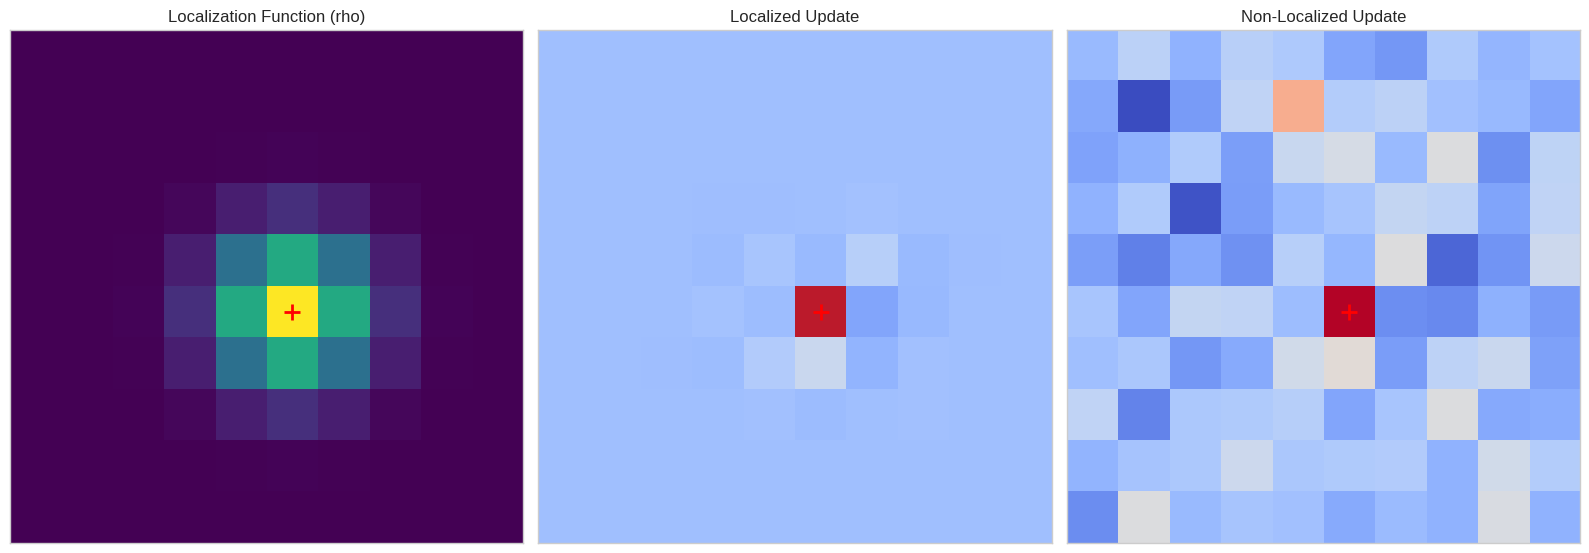

In [3]:
Nx, Ny = 10, 10
N_m = Nx * Ny
N_e = 50
x_obs, y_obs = 5, 5

seed = 42

alpha_i = 1
obs_error_var = 0.01

true_parameters = np.zeros(N_m)
true_observations = np.array([1.0])
C_D = np.array([obs_error_var])

# --- Generate Initial Ensemble and Predictions ---
rng = np.random.default_rng(seed)
X_prior = rng.normal(loc=0.0, scale=0.5, size=(N_m, N_e))

# Convert the 2D observation index to a flat 1D index for slicing
flat_obs_index = y_obs * Nx + x_obs
Y = X_prior[[flat_obs_index], :]

# --- Construct 2D Localization `rho` ---
localization_radius = 1

# Create a 2D coordinate grid
xx, yy = np.meshgrid(np.arange(Nx), np.arange(Ny))
# Calculate 2D Euclidean distance from every point to the observation
distances_2d = np.sqrt((xx - x_obs) ** 2 + (yy - y_obs) ** 2)
# Flatten the 2D distance map to a 1D vector to match the parameter vector
distances = distances_2d.flatten()

rho = np.exp(-0.5 * (distances / localization_radius) ** 2).reshape(-1, 1)

# --- Run Assimilations ---
esmda_distance = DistanceESMDA(
    covariance=C_D, observations=true_observations, alpha=alpha_i, seed=rng
)
X_posterior = esmda_distance.assimilate(X=X_prior, Y=Y, rho=rho)

esmda = ESMDA(covariance=C_D, observations=true_observations, alpha=alpha_i, seed=rng)
X_posterior_global = esmda.assimilate(X=X_prior, Y=Y)

# --- Reshape Data for Plotting ---
# Reshape the 1D vectors back into 2D grids for visualization
prior_mean = np.mean(X_prior, axis=1)
prior_mean_2d = prior_mean.reshape((Ny, Nx))
posterior_mean = np.mean(X_posterior, axis=1)
posterior_mean_2d = posterior_mean.reshape((Ny, Nx))

posterior_mean_global = np.mean(X_posterior_global, axis=1)
posterior_mean_global_2d = posterior_mean_global.reshape((Ny, Nx))
rho_2d = rho.reshape((Ny, Nx))

# It's often more insightful to visualize the UPDATE (posterior - prior)
update_localized_2d = posterior_mean_2d - prior_mean_2d
update_global_2d = posterior_mean_global_2d - prior_mean_2d

# --- Create the Plots ---
# Use a 2x3 grid to show the most important comparisons
fig, axes = plt.subplots(1, 3, figsize=(16, 10))

# Find the min/max across both update fields for a fair comparison
update_min = min(update_localized_2d.min(), update_global_2d.min())
update_max = max(update_localized_2d.max(), update_global_2d.max())

# Localization Function (rho)
im = axes[0].imshow(rho_2d, cmap="viridis")
axes[0].set_title("Localization Function (rho)")

# Localized Update
im = axes[1].imshow(
    update_localized_2d, cmap="coolwarm", vmin=update_min, vmax=update_max
)
axes[1].set_title("Localized Update")

# Non-Localized Update
im = axes[2].imshow(update_global_2d, cmap="coolwarm", vmin=update_min, vmax=update_max)
axes[2].set_title("Non-Localized Update")

# Mark the observation location on all plots and hide ticks
for ax in axes.flat:
    ax.plot(x_obs, y_obs, "r+", markersize=12, markeredgewidth=2)  # Red cross
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout(rect=[0, 0, 1, 0.96])

# 3D case

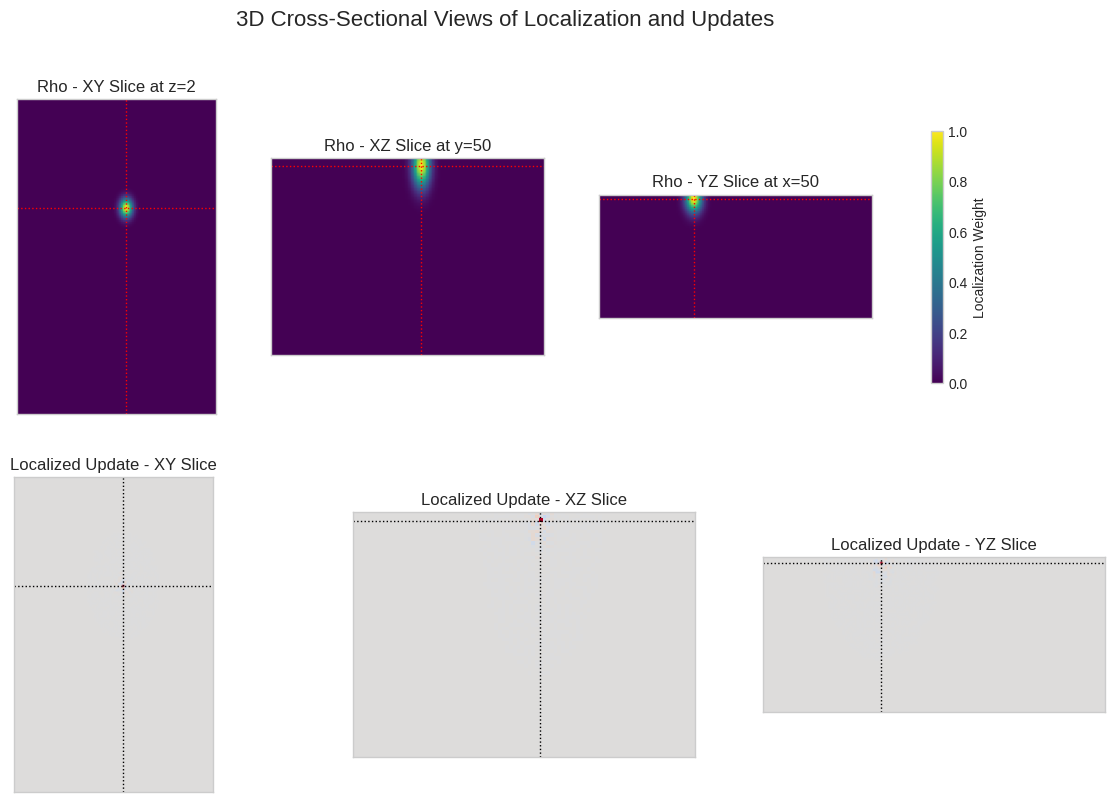

In [4]:
Nx, Ny, Nz = 92, 146, 66
N_m = Nx * Ny * Nz
N_e = 100
x_obs, y_obs, z_obs = 50, 50, 2

seed = 42
alpha_i = 1
obs_error_var = 0.01

true_parameters = np.zeros(N_m)
true_observations = np.array([1.0])
C_D = np.array([obs_error_var])

# --- Generate Initial Ensemble and Predictions ---
rng = np.random.default_rng(seed)
X_prior = rng.normal(loc=0.0, scale=0.5, size=(N_m, N_e))

# Convert the 3D observation index to a flat 1D index for slicing
flat_obs_index = (z_obs * Nx * Ny) + (y_obs * Nx) + x_obs
Y = X_prior[[flat_obs_index], :]

# gmour 2025.07.24
# --- Construct 3D Localization `rho` ---
localization_radius_x = 2.0
localization_radius_y = 3.0
localization_radius_z = 5.0

# Create 3D coordinate grids
zz, yy, xx = np.meshgrid(np.arange(Nz), np.arange(Ny), np.arange(Nx), indexing="ij")

# gmour 2025.07.24
# Calculate 3D Euclidean distance from every point to the observation
distances_3d = np.sqrt(
    ((xx - x_obs) / localization_radius_x) ** 2
    + ((yy - y_obs) / localization_radius_y) ** 2
    + ((zz - z_obs) / localization_radius_z) ** 2
)
distances = distances_3d.flatten()

rho = np.exp(-0.5 * distances**2).reshape(-1, 1)

# --- Run Assimilations ---
# This part remains the same as the assimilation logic is dimension-agnostic
esmda_distance = DistanceESMDA(
    covariance=C_D, observations=true_observations, alpha=alpha_i, seed=rng
)
X_posterior = esmda_distance.assimilate(X=X_prior, Y=Y, rho=rho)

esmda = ESMDA(covariance=C_D, observations=true_observations, alpha=alpha_i, seed=rng)
X_posterior_global = esmda.assimilate(X=X_prior, Y=Y)

# --- Reshape Data and Prepare for 3D Visualization ---
prior_mean = np.mean(X_prior, axis=1)
posterior_mean = np.mean(X_posterior, axis=1)

# Reshape the 1D vectors into 3D volumes
rho_3d = rho.reshape((Nz, Ny, Nx))
update_localized_3d = (posterior_mean - prior_mean).reshape((Nz, Ny, Nx))
update_global_3d = (np.mean(X_posterior_global, axis=1) - prior_mean).reshape(
    (Nz, Ny, Nx)
)

# --- Create 3D Cross-Sectional Plots ---
fig, axes = plt.subplots(2, 3, figsize=(15, 9))
fig.suptitle("3D Cross-Sectional Views of Localization and Updates", fontsize=16)

# --- Row 1: Slices of the Localization Function (rho) ---
im_rho = axes[0, 0].imshow(rho_3d[z_obs, :, :], cmap="viridis", vmin=0, vmax=1)
axes[0, 0].set_title(f"Rho - XY Slice at z={z_obs}")

axes[0, 1].imshow(rho_3d[:, y_obs, :], cmap="viridis", vmin=0, vmax=1)
axes[0, 1].set_title(f"Rho - XZ Slice at y={y_obs}")

axes[0, 2].imshow(rho_3d[:, :, x_obs], cmap="viridis", vmin=0, vmax=1)
axes[0, 2].set_title(f"Rho - YZ Slice at x={x_obs}")

fig.colorbar(
    im_rho, ax=axes[0, :], location="right", shrink=0.8, label="Localization Weight"
)

# --- Slices of the Update Fields ---
# Find a single, symmetric color scale for both update plots
update_max_abs = np.max([np.abs(update_localized_3d), np.abs(update_global_3d)])
vmin_update, vmax_update = -update_max_abs, update_max_abs

# Localized Update
im_update = axes[1, 0].imshow(
    update_localized_3d[z_obs, :, :],
    cmap="coolwarm",
    vmin=vmin_update,
    vmax=vmax_update,
)
axes[1, 0].set_title("Localized Update - XY Slice")

axes[1, 1].imshow(
    update_localized_3d[:, y_obs, :],
    cmap="coolwarm",
    vmin=vmin_update,
    vmax=vmax_update,
)
axes[1, 1].set_title("Localized Update - XZ Slice")

axes[1, 2].imshow(
    update_localized_3d[:, :, x_obs],
    cmap="coolwarm",
    vmin=vmin_update,
    vmax=vmax_update,
)
axes[1, 2].set_title("Localized Update - YZ Slice")

# --- Add Annotations to All Plots ---
# Add crosshairs to pinpoint the observation location in each slice
axes[0, 0].axhline(y_obs, color="r", linestyle=":", lw=1)
axes[0, 0].axvline(x_obs, color="r", linestyle=":", lw=1)
axes[0, 1].axhline(z_obs, color="r", linestyle=":", lw=1)
axes[0, 1].axvline(x_obs, color="r", linestyle=":", lw=1)
axes[0, 2].axhline(z_obs, color="r", linestyle=":", lw=1)
axes[0, 2].axvline(y_obs, color="r", linestyle=":", lw=1)

axes[1, 0].axhline(y_obs, color="k", linestyle=":", lw=1)
axes[1, 0].axvline(x_obs, color="k", linestyle=":", lw=1)
axes[1, 1].axhline(z_obs, color="k", linestyle=":", lw=1)
axes[1, 1].axvline(x_obs, color="k", linestyle=":", lw=1)
axes[1, 2].axhline(z_obs, color="k", linestyle=":", lw=1)
axes[1, 2].axvline(y_obs, color="k", linestyle=":", lw=1)

# Hide axis ticks for a cleaner look
for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

# Performance

In [5]:
import time

import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import IntSlider, interact

from iterative_ensemble_smoother.experimental import DistanceESMDA


def gaspari_cohn_localization(distances, radius):
    """Gaspari-Cohn localization with compact support at 2*radius"""
    r = distances / radius
    rho = np.zeros_like(r)

    # Compact support: zero beyond 2*radius
    mask1 = r <= 1
    mask2 = (r > 1) & (r <= 2)

    # Gaspari-Cohn function with smooth derivatives
    rho[mask1] = (
        1
        - (5 / 3) * r[mask1] ** 2
        + (5 / 8) * r[mask1] ** 3
        + (1 / 2) * r[mask1] ** 4
        - (1 / 4) * r[mask1] ** 5
    )
    rho[mask2] = (
        4
        - 5 * r[mask2]
        + (5 / 3) * r[mask2] ** 2
        + (5 / 8) * r[mask2] ** 3
        - (1 / 2) * r[mask2] ** 4
        + (1 / 12) * r[mask2] ** 5
        - 2 / (3 * r[mask2])
    )

    return rho


def create_multi_well_localization(
    well_locations, obs_per_well, grid_size, radii_azimuth
):
    """Create localization matrix where all observations at same well share localization

    Parameters:
    -----------
    well_locations : array_like
        Indices of well locations
    obs_per_well : int
        Number of observations per well
    grid_size : int
        Size of square grid (grid_size x grid_size)
    radius : float
        Localization radius (function has compact support at 2*radius)

    Returns:
    --------
    rho : ndarray
        Localization matrix of shape (n_params, n_obs)
    """

    n_wells = len(well_locations)
    n_obs = n_wells * obs_per_well
    n_params = grid_size * grid_size

    # Create coordinate grids
    xx, yy = np.meshgrid(np.arange(grid_size), np.arange(grid_size))

    xx_flat = xx.flatten()
    yy_flat = yy.flatten()

    rho = np.zeros((n_params, n_obs))

    for current_index, well_idx in enumerate(well_locations):
        # Convert 1D grid index to 2D coordinates
        # For a flattened grid: index = y * grid_size + x
        # So: x = index % grid_size, y = index // grid_size
        well_x = well_idx % grid_size
        well_y = well_idx // grid_size

        # Perform a simple 2D rotation. Equations available in:
        # Emerick, A., & Reynolds, A. (2011). Combining sensitivities and prior information for covariance localization
        # in the ensemble Kalman filter for petroleum reservoir applications. Computational Geosciences, 15(2), 251-269.
        # Equations #18 and #19

        rotated_x_dist = (xx_flat - well_x) * np.cos(radii_azimuth[2] * np.pi / 180) + (
            yy_flat - well_y
        ) * np.sin(radii_azimuth[2] * np.pi / 180)
        rotated_y_dist = -(xx_flat - well_x) * np.sin(
            radii_azimuth[2] * np.pi / 180
        ) + (yy_flat - well_y) * np.cos(radii_azimuth[2] * np.pi / 180)

        distances = np.sqrt(
            (rotated_x_dist / radii_azimuth[0]) ** 2
            + (rotated_y_dist / radii_azimuth[1]) ** 2
        )

        rho_well = gaspari_cohn_localization(distances, 1)

        # Populate rho by replicating rho_well obs_per_well times:
        rho[:, current_index * obs_per_well : (current_index + 1) * obs_per_well] = (
            np.tile(rho_well.reshape(-1, 1), (1, obs_per_well))
        )

    return rho


def visualize_localization_effect(
    X_prior, X_posterior, well_locations, rho, grid_size, case_name=""
):
    """Visualize the localization function and its effect on the update"""

    # Calculate ensemble means
    prior_mean = np.mean(X_prior, axis=1)
    posterior_mean = np.mean(X_posterior, axis=1)

    # Reshape to 2D grids
    prior_mean_2d = prior_mean.reshape((grid_size, grid_size))
    posterior_mean_2d = posterior_mean.reshape((grid_size, grid_size))
    rho_2d = rho[:, 0].reshape(
        (grid_size, grid_size)
    )  # Use first column since all are the same

    # Calculate update
    update_2d = posterior_mean_2d - prior_mean_2d

    # Convert well locations to 2D coordinates
    well_coords = [(idx % grid_size, idx // grid_size) for idx in well_locations]

    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot 1: Localization function
    im1 = axes[0].imshow(rho_2d, cmap="viridis", origin="lower")
    axes[0].set_title("Localization Function (rho)")
    axes[0].set_xlabel("X coordinate")
    axes[0].set_ylabel("Y coordinate")
    plt.colorbar(im1, ax=axes[0])

    # Mark well locations
    for well_x, well_y in well_coords:
        axes[0].plot(well_x, well_y, "r+", markersize=15, markeredgewidth=3)

    # Plot 2: Localized update
    update_max = max(abs(update_2d.min()), abs(update_2d.max()))
    im2 = axes[1].imshow(
        update_2d, cmap="RdBu_r", origin="lower", vmin=-update_max, vmax=update_max
    )
    axes[1].set_title("Localized Update")
    axes[1].set_xlabel("X coordinate")
    axes[1].set_ylabel("Y coordinate")
    plt.colorbar(im2, ax=axes[1])

    # Mark well locations
    for well_x, well_y in well_coords:
        axes[1].plot(well_x, well_y, "k+", markersize=15, markeredgewidth=3)

    plt.suptitle(f"Localization Effect {case_name}", fontsize=14)
    plt.tight_layout()
    plt.show()

    # Print some statistics
    print("    Localization statistics:")
    print(
        f"      Sparsity: {np.mean(rho_2d == 0) * 100:.1f}% of parameters have zero localization"
    )
    print(f"      Max localization: {rho_2d.max():.3f}")
    print(f"      Update range: [{update_2d.min():.4f}, {update_2d.max():.4f}]")
    print(f"      Update std: {update_2d.std():.4f}")
    print(f"      Rho shape: {rho.shape}")


def visualize_localization_effect_interactive(
    X_prior, X_posterior, well_locations, rho, grid_size, case_name=""
):
    """Interactive visualization of the localization function and its effect on the update"""

    # Calculate ensemble means
    prior_mean = np.mean(X_prior, axis=1)
    posterior_mean = np.mean(X_posterior, axis=1)

    # Reshape to 2D grids
    prior_mean_2d = prior_mean.reshape((grid_size, grid_size))
    posterior_mean_2d = posterior_mean.reshape((grid_size, grid_size))

    # Calculate update
    update_2d = posterior_mean_2d - prior_mean_2d

    # Convert well locations to 2D coordinates
    well_coords = [(idx % grid_size, idx // grid_size) for idx in well_locations]

    def plot_slice(slice_index):
        rho_2d = rho[:, slice_index].reshape((grid_size, grid_size))

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        # Plot 1: Localization function
        im1 = axes[0].imshow(rho_2d, cmap="viridis", origin="lower")
        axes[0].set_title(f"Localization Function (rho[:, {slice_index}])")
        axes[0].set_xlabel("X coordinate")
        axes[0].set_ylabel("Y coordinate")
        plt.colorbar(im1, ax=axes[0])

        for well_x, well_y in well_coords:
            axes[0].plot(well_x, well_y, "r+", markersize=15, markeredgewidth=3)

        # Plot 2: Localized update
        update_max = max(abs(update_2d.min()), abs(update_2d.max()))
        im2 = axes[1].imshow(
            update_2d, cmap="RdBu_r", origin="lower", vmin=-update_max, vmax=update_max
        )
        axes[1].set_title("Localized Update")
        axes[1].set_xlabel("X coordinate")
        axes[1].set_ylabel("Y coordinate")
        plt.colorbar(im2, ax=axes[1])

        for well_x, well_y in well_coords:
            axes[1].plot(well_x, well_y, "k+", markersize=15, markeredgewidth=3)

        plt.suptitle(f"Localization Effect {case_name}", fontsize=14)
        plt.tight_layout()
        plt.show()

        # Print statistics
        print(f"    Localization statistics for slice {slice_index}:")
        print(
            f"      Sparsity: {np.mean(rho_2d == 0) * 100:.1f}% of parameters have zero localization"
        )
        print(f"      Max localization: {rho_2d.max():.3f}")
        print(f"      Update range: [{update_2d.min():.4f}, {update_2d.max():.4f}]")
        print(f"      Update std: {update_2d.std():.4f}")
        print(f"      Rho shape: {rho.shape}")

    # Create interactive slider
    interact(
        plot_slice, slice_index=IntSlider(min=0, max=rho.shape[1] - 1, step=1, value=0)
    )


def time_large_scale_performance():
    """Test performance on large-scale problems"""

    # Test cases: (n_params, n_wells, obs_per_well)
    test_cases = [
        (200 * 200, 100, 1),
        # (115*115, 115*115, 1),
        # (418*418, 115*115, 1),
        # (660*660, 115*115, 1),
        # (933 * 933, 60 * 60, 1),
        # (100*100, 5, 1000),
        # (1000*1000, 50, 20),
        # (1000*1000, 100, 10),
    ]

    n_ensemble = 100
    n_trials = 1  # Might want to reduce this for very large problems
    # main, normal, azimuth
    localization_radii_azimuth = [50, 30, 45]

    results = []

    print("Testing large-scale performance...")
    print("=" * 50)

    for i, (n_params, n_wells, obs_per_well) in enumerate(test_cases):
        n_obs = n_wells * obs_per_well
        print(
            f"\nTest Case {i + 1}: N_params={n_params:,}, N_wells={n_wells}, Obs_per_well={obs_per_well}, Total_obs={n_obs}"
        )

        grid_size = int(np.sqrt(n_params))
        print(
            f"Grid: {grid_size}x{grid_size}, Wells: {n_wells}, Obs/well: {obs_per_well}"
        )

        # Verify it's a perfect square
        assert grid_size * grid_size == n_params, f"Not a perfect square: {n_params}"

        trial_times = []

        for trial in range(n_trials):
            print(f"  Trial {trial + 1}/{n_trials}...")

            # Setup
            # rng = np.random.default_rng(42 + trial)
            rng = np.random.default_rng()

            # Generate ensemble
            print("    Generating ensemble...")
            X_prior = rng.normal(0, 0.5, size=(n_params, n_ensemble))

            # Generate well locations and observations
            print("    Selecting well locations and observations...")

            # First, select well locations (unique spatial positions)
            well_locations = rng.choice(n_params, size=n_wells, replace=False)

            # Then, create multiple observations per well
            # For simplicity, all observations at a well have the same location
            # In reality, they might be slightly offset or represent different variables
            obs_indices = []
            for well_loc in well_locations:
                for _ in range(obs_per_well):
                    obs_indices.append(well_loc)

            # Generate observations by sampling the forward model at well locations
            # Note: obs_indices can be longer than n_params since we replicate well locations
            # for multiple observations per well. NumPy allows repeated indices, so
            # X_prior[obs_indices, :] creates multiple copies of the same model values.
            obs_indices = np.array(obs_indices)
            # Using identity model Y = g(X) = X
            Y = X_prior[obs_indices, :]

            # Start timing the critical section
            start_time = time.perf_counter()

            print("    Creating localization matrix...")

            # Create localization matrix based on well locations
            # All observations at same well share same localization
            rho = create_multi_well_localization(
                well_locations, obs_per_well, grid_size, localization_radii_azimuth
            )

            print("    Running assimilation...")

            # Run assimilation with all observations
            esmda = DistanceESMDA(
                covariance=np.eye(n_obs) * 0.01,
                observations=np.ones(n_obs),
                alpha=1,
                seed=rng,
            )

            X_posterior = esmda.assimilate(X=X_prior, Y=Y, rho=rho)

            end_time = time.perf_counter()

            total_time = end_time - start_time
            trial_times.append(total_time)

            print(f"    Time: {total_time:.2f}s")

            # Visualize the localization effect
            print("    Creating visualization...")
            visualize_localization_effect_interactive(
                X_prior,
                X_posterior,
                well_locations,
                rho,
                grid_size,
                case_name=f"(Case {i + 1}: {n_wells} wells, {obs_per_well} obs/well, radii and azimuth={localization_radii_azimuth})",
            )

            # Clean up large arrays to free memory
            del X_prior, X_posterior, Y, rho

        avg_time = np.mean(trial_times)
        std_time = np.std(trial_times)

        result = {
            "n_params": n_params,
            "n_wells": n_wells,
            "obs_per_well": obs_per_well,
            "n_obs": n_obs,
            "avg_time": avg_time,
            "std_time": std_time,
            "trial_times": trial_times,
        }
        results.append(result)

        print(f"  Average time: {avg_time:.2f} ± {std_time:.2f}s")
        print(f"  Time per parameter: {avg_time / n_params * 1e6:.2f} μs/param")
        print(f"  Time per well: {avg_time / n_wells * 1e3:.2f} ms/well")
        print(f"  Time per observation: {avg_time / n_obs * 1e3:.2f} ms/obs")

    return results


def analyze_large_scale_results(results):
    """Analyze and visualize large-scale results"""

    print("\n" + "=" * 60)
    print("LARGE-SCALE PERFORMANCE ANALYSIS")
    print("=" * 60)

    for i, result in enumerate(results):
        print(
            f"\nCase {i + 1}: {result['n_params']:,} params, {result['n_wells']} wells, {result['obs_per_well']} obs/well"
        )
        print(f"  Total obs: {result['n_obs']}")
        print(
            f"  Total time: {result['avg_time']:.2f} ± {result['std_time']:.2f} seconds"
        )
        print(
            f"  Throughput: {result['n_params'] / result['avg_time']:.0f} params/second"
        )
        print(
            f"  Time per param: {result['avg_time'] / result['n_params'] * 1e6:.2f} μs"
        )
        print(f"  Time per well: {result['avg_time'] / result['n_wells'] * 1e3:.2f} ms")
        print(f"  Time per obs: {result['avg_time'] / result['n_obs'] * 1e3:.2f} ms")


# Performance monitoring decorator (simplified)
def monitor_performance(func):
    """Decorator to monitor time only"""

    def wrapper(*args, **kwargs):
        start_time = time.perf_counter()

        result = func(*args, **kwargs)

        end_time = time.perf_counter()

        print(f"Function {func.__name__}:")
        print(f"  Total time: {end_time - start_time:.2f}s")

        return result

    return wrapper


# Modified main execution
if __name__ == "__main__":
    time_large_scale_performance = monitor_performance(time_large_scale_performance)

    results = time_large_scale_performance()
    analyze_large_scale_results(results)

Testing large-scale performance...

Test Case 1: N_params=40,000, N_wells=100, Obs_per_well=1, Total_obs=100
Grid: 200x200, Wells: 100, Obs/well: 1
  Trial 1/1...
    Generating ensemble...
    Selecting well locations and observations...
    Creating localization matrix...
    Running assimilation...
    Time: 0.17s
    Creating visualization...


interactive(children=(IntSlider(value=0, description='slice_index', max=99), Output()), _dom_classes=('widget-…

  Average time: 0.17 ± 0.00s
  Time per parameter: 4.17 μs/param
  Time per well: 1.67 ms/well
  Time per observation: 1.67 ms/obs
Function time_large_scale_performance:
  Total time: 0.52s

LARGE-SCALE PERFORMANCE ANALYSIS

Case 1: 40,000 params, 100 wells, 1 obs/well
  Total obs: 100
  Total time: 0.17 ± 0.00 seconds
  Throughput: 239986 params/second
  Time per param: 4.17 μs
  Time per well: 1.67 ms
  Time per obs: 1.67 ms


# Extended 3D case for multiple purpose testing



Field size (nx, ny, nz) = (92,146,66)
Localization x-range: 1725.0
Localization y-range: 2737.5
Localization ellipse rotation angle: 0.0
Simulate prior fields
Simulate realization: 0
Simulate realization: 10
Simulate realization: 20
Simulate realization: 30
Simulate realization: 40
Simulate realization: 50
Simulate realization: 60
Simulate realization: 70
Simulate realization: 80
Simulate realization: 90
Observation distance in x direction: 150.0
Observation distance in y direction: 150.0
obs_grid_nx: 46
obs_grid_ny: 73
Define observation values (Use a spatial trend). Number of obs = 3358
Use correlated observations: True
Define spatial correlation between observation errors.
Obs correlation length in x = 69.0
Obs correlation length in y = 109.5
Obs correlation length in number of observation distances in x direction =1
Obs correlation length in number of observation distances in y direction =1
Spatial correlation defined by correlation function exp(-3*d^power)with  power: 1.85 and d i

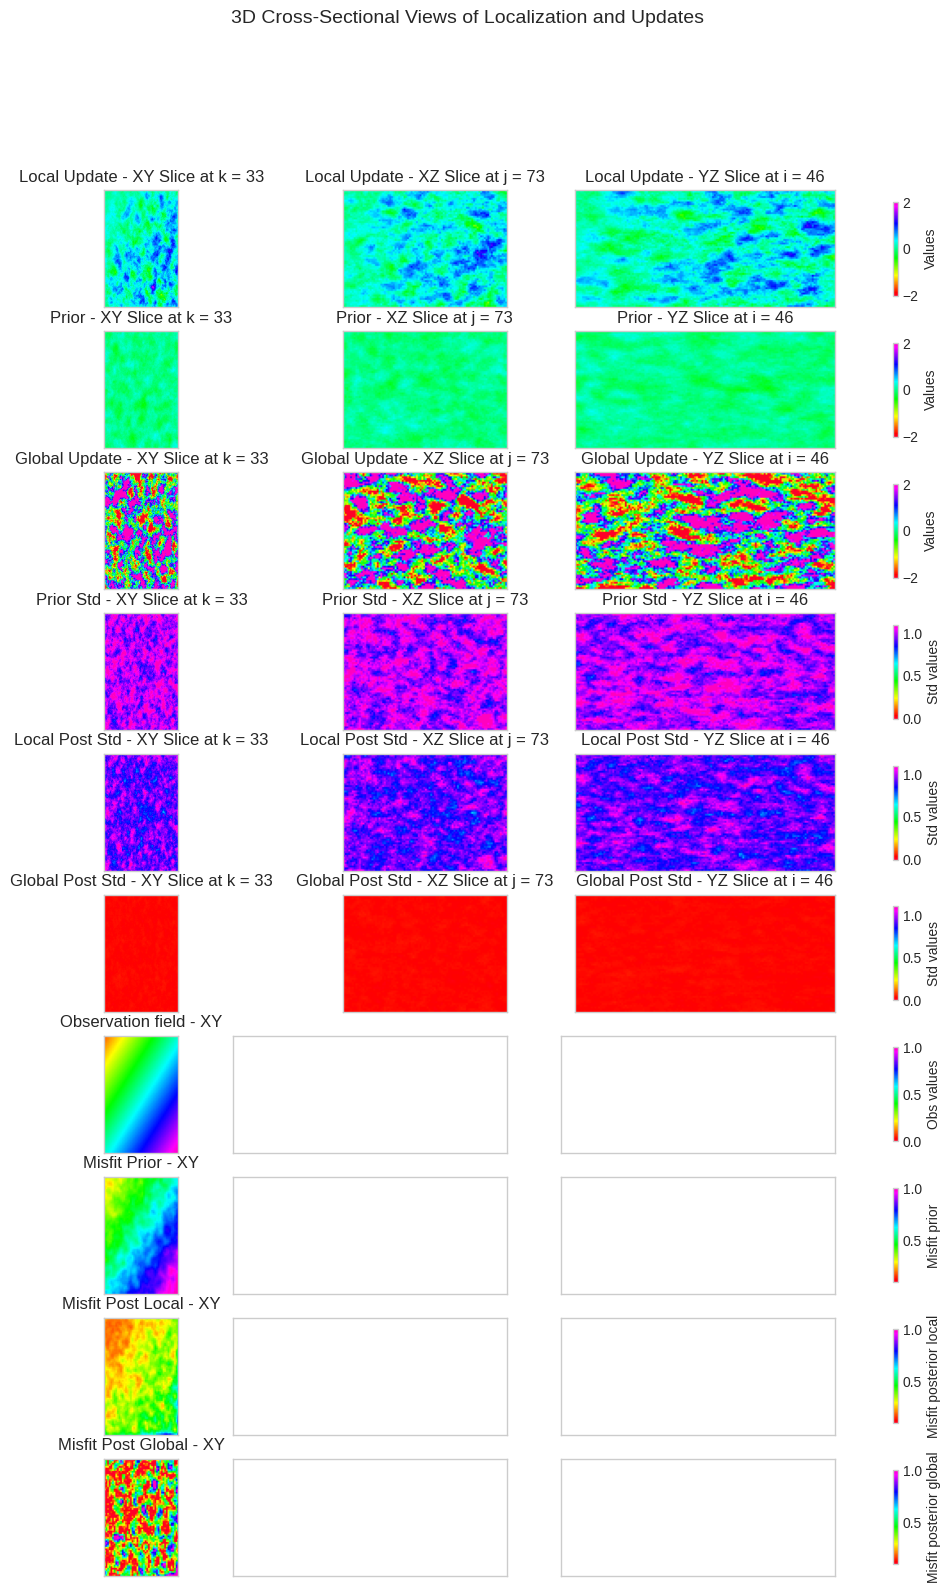

In [ ]:
import math

import gaussianfft as sim


# This test uses a forward model that is an aritmetic average
# of the field parameters into a coarse scale grid
def simulate_realizations(
    nreal: int,
    variogram,
    nx: int,
    ny: int,
    nz: int,
    xinc: float,
    yinc: float,
    zinc: float,
    start_seed: int = 123456789,
) -> np.ndarray:
    """
    Draw realizations of the 3D gaussian fields using specified variogram
    Output has dimension (nparam, nreal) where nparam = nx*ny*nz
    The flatten parameter vector is 'F'-ordered where (i,j,k)
    corresponds to index = i + j*nx + k*nx*ny
    """
    sim.seed(start_seed)
    fields = np.zeros((nx * ny * nz, nreal), dtype=np.float32)
    for n in range(nreal):
        if n % 10 == 0:
            print(f"Simulate realization: {n}")
        # Order is 'F' as output here
        field_real_flatten = sim.simulate(variogram, nx, xinc, ny, yinc, nz, zinc)
        fields[:, n] = field_real_flatten
    return fields


def forward_model_real(
    field3D: np.ndarray, nx: int, ny: int, nz: int, kx: int, ky: int, kz: int
) -> np.ndarray:
    """
    Simple linear forward model defined by arithmetic average of field
    values within each coarse grid cell.
    Calculate average of coarse grid blocks of size (mx,my,mz).
    nx = mx*kx,   ny = my *ky , nz = mz * kz
    where (kx, ky,kz) is grid size of upscaled grid.

    """
    mx = int(nx / kx)
    my = int(ny / ky)
    mz = int(nz / kz)
    upscaled = np.zeros((kx, ky, kz), order="F", dtype=np.float32)
    for kk in range(kz):
        zstart = kk * mz
        zend = zstart + mz
        for jj in range(ky):
            ystart = jj * my
            yend = ystart + my
            for ii in range(kx):
                xstart = ii * mx
                xend = xstart + mx
                selected = field3D[xstart:xend, ystart:yend, zstart:zend]
                avg = np.mean(selected)
                upscaled[ii, jj, kk] = avg
    return upscaled


def forward_model(
    fields: np.ndarray, nreal: int, nx: int, ny: int, nz: int, kx: int, ky: int, kz: int
) -> np.ndarray:
    """
    Apply the forward model to all realizations.
    The response per realization (the upscaled values)
    are saved in flatten array. Keep same index order ('F')
    for coarse grid values as for the input field.
    """
    upscaled_fields = np.zeros((kx * ky * kz, nreal), dtype=np.float32)
    for n in range(nreal):
        field = fields[:, n]
        field3D = field.reshape((nx, ny, nz), order="F")
        upscaled3D = forward_model_real(field3D, nx, ny, nz, kx, ky, kz)
        upscaled_fields[:, n] = upscaled3D.flatten(order="F")
    return upscaled_fields


def gaussian_decay(D):
    return np.exp(-3 * D * D)


def exponential_decay(D):
    return np.exp(-3 * D)


def field_parameter_grid_cell_center_xy_coordinates(
    xorigo: float,
    yorigo: float,
    xinc: float,
    yinc: float,
    rotation: float,
    nx: int,
    ny: int,
):
    """
    Calculate global x and y coordinates grid cell center points
    of field parameter grid as mesh.
    Input:
    Field parameter grid has a global rotation point, typically
    this is lower left corner point if the grid is unrotated.
    Rotation is anticlockwise in degrees. Only the lateral position of
    the grid cell center points are of interest for distance based
    localization.
    Output:
    Numpy mesh for x and y location of cell center points in global coordinates
    """
    x_local = np.arange(0.5 * xinc, xinc * (nx + 0.49), xinc, dtype=np.float32)
    y_local = np.arange(0.5 * yinc, yinc * (ny + 0.49), yinc, dtype=np.float32)

    cosangle = math.cos(rotation * np.pi / 180.0)
    sinangle = math.sin(rotation * np.pi / 180.0)

    # (x,y) in local coordinate system following simulation box
    yy, xx = np.meshgrid(y_local, x_local, indexing="ij")

    # Transform to global coordinate system
    x_global = xx * cosangle - yy * sinangle + xorigo
    y_global = xx * sinangle + yy * cosangle + yorigo
    return x_global, y_global


def calculate_scaling_factor_for_one_layer(
    obs_xpos: float,
    obs_ypos: float,
    grid_x_coord: np.ndarray,
    grid_y_coord: np.ndarray,
    main_range: float,
    perp_range: float,
    ellipse_rotation: float,
    scaling_function,
    cutoff_value: float = 0.001,
) -> np.ndarray:
    """
    Calculate scaling factors for all pairs of field parameters
    and one observation point of a layer in a 3D field
    parameter grid (box grid).
    Input:
    numpy mesh for x and y coordinates of cell centers of field
    parameter grid position. Position of observation must be
    in the same coordinates. Localization parameters for distance
    and rotation of elliptic influence area.
    Rotation of ellipse is relative to the coordinate system used.
    If used coordinate system is local (simulation box grid),
    the rotation angle is relative to the local coordinate x-axis.
    If coordinate system is global (e.g.UTM), the rotation
    angle is relative to the west-east x-axis.
    Output:
    scaling factors for all field parameters for one grid layer of
    field parameters around observation point given.
    """
    dX = grid_x_coord - obs_xpos
    dY = grid_y_coord - obs_ypos
    rotation = ellipse_rotation * np.pi / 180.0
    cosangle = math.cos(rotation)
    sinangle = math.sin(rotation)
    #    print(f"shape of dX: {dX.shape} ")
    #    print(f"shape of dY: {dY.shape} ")
    dX_ellipse = (dX * cosangle + dY * sinangle) / main_range
    dY_ellipse = (-dX * sinangle + dY * cosangle) / perp_range
    distances_2d = np.sqrt(dX_ellipse * dX_ellipse + dY_ellipse * dY_ellipse)
    distances = distances_2d.flatten()
    scaling_factors = scaling_function(distances)

    # Apply cutoff
    scaling_factors[scaling_factors < cutoff_value] = 0.0
    #    print(f"Shape of scaling_factor: {scaling_factor_all.shape} ")
    return scaling_factors


def calculate_rho_for_2d_obs_field(
    grid_xlength: float,
    grid_ylength: float,
    param_grid_nx: int,
    param_grid_ny: int,
    obs_grid_nx: int,
    obs_grid_ny: int,
    local_main_range: int,
    local_perp_range: int,
    local_rotation: float,
    tapering_function_name: str,
    cutoff_value: float = 0.0,
) -> np.ndarray:
    """
    Calculate localization scaling factor pairs of field parameters and observations.
    Input:
    The field parameter is specified on a box grid with origo in global coordinates
    and grid orientation relative to global coordinates (e.g UTM). Rotation angle is
    positive anti-clockwise and in degrees.
    The size of the rectangular box is specified.
    The observations are assumed to be located on a 2D grid oriented and located and
    with position as the field parameter grid and with same size.
    The grid resolution (increments) of the 2D grid with observations can be different
    from the field parameter grid.
    The specified localization ranges define the influence range of the localization and
    are parameters used by the specified localization function.
    Output:
    Update the matrix rho corresponding to one layer of the 3D field parameter grid
    with scaling factors for each pair of field parameters and observations.
    """

    nparam_one_layer = param_grid_nx * param_grid_ny
    nobs = obs_grid_nx * obs_grid_ny
    if param_grid_nx == obs_grid_nx and param_grid_ny == obs_grid_ny:
        if local_main_range == 0.0 or local_perp_range == 0.0:
            # localization with 0 influence range means that only the observation
            # located in same position as the field parameter contributes to the
            # update of the field parameter.
            # (Co-located field parameter and observation)
            print(
                "Field parameters (x,y) position and (i,j) indices are co-located with"
                "the observation field"
            )
            rho_for_one_layer = np.identity(nparam_one_layer, dtype=np.float32)
            return rho_for_one_layer
    # TODO:  Can maybe speed up this
    xinc = grid_xlength / param_grid_nx
    yinc = grid_ylength / param_grid_ny
    xinc_obs = grid_xlength / obs_grid_nx
    yinc_obs = grid_ylength / obs_grid_ny

    x_local = np.arange(param_grid_nx)
    x_local = (x_local + 0.5) * xinc
    y_local = np.arange(param_grid_ny)
    y_local = (y_local + 0.5) * yinc
    grid_y_coord, grid_x_coord = np.meshgrid(y_local, x_local, indexing="ij")

    if tapering_function_name == "exponential":
        scaling_function = exponential_decay
    elif tapering_function_name == "gaussian":
        scaling_function = gaussian_decay

    # Position relative to the local coordinate system (simbox coordinate system)
    rho_for_one_layer = np.zeros((nparam_one_layer, nobs))
    for j in range(obs_grid_ny):
        y_pos_obs = (j + 0.5) * yinc_obs
        for i in range(obs_grid_nx):
            obs_nr = i + j * obs_grid_nx
            x_pos_obs = (i + 0.5) * xinc_obs
            rho_for_one_layer[:, obs_nr] = calculate_scaling_factor_for_one_layer(
                x_pos_obs,
                y_pos_obs,
                grid_x_coord,
                grid_y_coord,
                local_main_range,
                local_perp_range,
                local_rotation,
                scaling_function,
                cutoff_value=cutoff_value,
            )

    return rho_for_one_layer


def calculate_rho_for_2d_obs_field_version2(
    grid_xlength: float,
    grid_ylength: float,
    param_grid_nx: int,
    param_grid_ny: int,
    obs_grid_nx: int,
    obs_grid_ny: int,
    local_main_range: int,
    local_perp_range: int,
    local_rotation: float,
    tapering_function_name: str,
    cutoff_value: float = 0.0,
) -> np.ndarray:
    """
    Calculate localization scaling factor pairs of field parameters and observations.
    Input:
    The field parameter is specified on a box grid with origo in global coordinates
    and grid orientation relative to global coordinates (e.g UTM). Rotation angle is
    positive anti-clockwise and in degrees.
    The size of the rectangular box is specified.
    The observations are assumed to be located on a 2D grid oriented and located and
    with position as the field parameter grid and with same size.
    The grid resolution (increments) of the 2D grid with observations can be different
    from the field parameter grid.
    The specified localization ranges define the influence range of the localization and
    are parameters used by the specified localization function.
    Output:
    Update the matrix rho corresponding to one layer of the 3D field parameter grid
    with scaling factors for each pair of field parameters and observations.
    """

    nparam_one_layer = param_grid_nx * param_grid_ny
    nobs = obs_grid_nx * obs_grid_ny
    if param_grid_nx == obs_grid_nx and param_grid_ny == obs_grid_ny:
        if local_main_range == 0.0 or local_perp_range == 0.0:
            # localization with 0 influence range means that only the observation
            # located in same position as the field parameter contributes to the
            # update of the field parameter.
            # (Co-located field parameter and observation)
            print(
                "Field parameters (x,y) position and (i,j) indices are co-located with"
                "the observation field"
            )
            rho_for_one_layer = np.identity(nparam_one_layer, dtype=np.float32)
            return rho_for_one_layer

    rho_for_one_layer = np.zeros((nparam_one_layer, nobs))
    selected_param_2d = np.zeros((param_grid_ny, param_grid_nx), dtype=bool)
    xinc = grid_xlength / param_grid_nx
    yinc = grid_ylength / param_grid_ny
    xinc_obs = grid_xlength / obs_grid_nx
    yinc_obs = grid_ylength / obs_grid_ny

    # localization range in number of field parameter grid cell increments
    used_number_of_ranges = 1.2
    irange = int((used_number_of_ranges * local_main_range / xinc) + 0.5)
    jrange = int((used_number_of_ranges * local_perp_range / yinc) + 0.5)

    obs_grid_xpos = np.arange(0.5 * xinc_obs, grid_xlength, xinc_obs)
    obs_grid_ypos = np.arange(0.5 * yinc_obs, grid_ylength, yinc_obs)

    # Calculate a template for scaling factors for localization for a neighbourhood
    # around one arbitrary position (Only distance is relevant here)
    # Choose position (0,0)
    a = xinc / local_main_range
    b = yinc / local_perp_range
    scaling_factor_template = np.zeros(
        (2 * irange + 1, 2 * jrange + 1), dtype=np.float32
    )
    DX = np.arange(-irange, irange + 1) * a
    DY = np.arange(-jrange, jrange + 1) * b
    yy, xx = np.meshgrid(DY, DX, indexing="ij")
    distances_2d = np.sqrt(xx**2 + yy**2)
    if tapering_function_name == "gaussian":
        scaling_factor_template = np.exp(-3.0 * distances_2d**2)
    elif tapering_function_name == "exponential":
        scaling_factor_template = np.exp(-3.0 * distances_2d)

    # For each observation point, calculate rho for those field parameters
    # influenced by the observation. Here we use the assumption that the 2D grid
    # with observations and a layer for the 3D grid with field parameters are
    # defined within the same rectangular area. Index interval of field parameters
    # within localization range are calculated for each observation and
    # used to calculate scaling factor (rho)
    for j in range(obs_grid_ny):
        ypos_obs = obs_grid_ypos[j]
        jj = int(ypos_obs / yinc)
        # imin, imax, jmax, jmax is the limit of indices for field parameters
        # that can be updated by current observation.
        # imin_selected, imax_selected, jmin_selected, jmax_selected are
        # index interval for the scaling_factor_template

        jmin = jj - jrange
        jmax = jj + jrange + 1
        jmin_selected = 0
        jmax_selected = 2 * jrange + 1
        if jmin < 0:
            jmin_selected = -jmin
            jmin = 0
        if jmax >= param_grid_ny:
            jmax_selected = 2 * jrange - (jmax - param_grid_ny) + 1
            jmax = param_grid_ny

        for i in range(obs_grid_nx):
            xpos_obs = obs_grid_xpos[i]
            ii = int(xpos_obs / xinc)
            obs_nr = i + j * obs_grid_nx
            imin = ii - irange
            imax = ii + irange + 1
            imin_selected = 0
            imax_selected = 2 * irange + 1
            if imin < 0:
                imin_selected = -imin
                imin = 0
            if imax >= param_grid_nx:
                imax_selected = 2 * irange - (imax - param_grid_nx) + 1
                imax = param_grid_nx

            selected_param_2d[:, :] = False
            selected_param_2d[jmin:jmax, imin:imax] = True
            selected_param = selected_param_2d.flatten()

            selected_scaling_factors_2d = scaling_factor_template[
                jmin_selected:jmax_selected, imin_selected:imax_selected
            ]
            selected_scaling_factors = selected_scaling_factors_2d.flatten()

            rho_for_one_layer[selected_param, obs_nr] = selected_scaling_factors

    return rho_for_one_layer


def define_example_observation_field(
    grid_xlength: float,
    grid_ylength: float,
    obs_grid_nx: int,
    obs_grid_ny: int,
) -> np.ndarray:
    # Define observation values for the observation grid
    nobs = obs_grid_nx * obs_grid_ny
    obs_xinc = grid_xlength / obs_grid_nx
    obs_yinc = grid_ylength / obs_grid_ny
    print(f"Observation distance in x direction: {obs_xinc}")
    print(f"Observation distance in y direction: {obs_yinc}")
    print(f"obs_grid_nx: {obs_grid_nx}")
    print(f"obs_grid_ny: {obs_grid_ny}")

    true_observations = np.zeros(nobs, dtype=np.float32)
    obs_value_inc_i = 0.45 / (obs_grid_nx - 1)
    obs_value_inc_j = 0.45 / (obs_grid_ny - 1)
    print(f"Define observation values (Use a spatial trend). Number of obs = {nobs}")
    obs_nr = 0
    for j in range(obs_grid_ny):
        for i in range(obs_grid_nx):
            true_observations[obs_nr] = 0.1 + obs_value_inc_i * i + obs_value_inc_j * j
            obs_nr += 1
    return true_observations


def obs_error_covariance(
    obs_error_std: float,
    obs_grid_nx: int,
    obs_grid_ny: int,
    grid_xlength: float = 0,
    grid_ylength: float = 0,
    use_obs_correlations: bool = False,
    obs_correlation_length_x: float = 0.0,
    obs_correlation_length_y: float = 0.0,
):
    """
    Define observation covariance matrix.
    Return covariance matrix of observations. Default is diagonal covariance.
    """
    print(f"Use correlated observations: {use_obs_correlations}")
    nobs = obs_grid_nx * obs_grid_ny
    obs_error_var = obs_error_std * obs_error_std
    # Correlated obs
    obs_variances = np.ones(nobs, dtype=np.float64)
    obs_variances = obs_error_var * obs_variances
    if use_obs_correlations:
        C_D = np.diag(obs_variances)
        power = 1.85
        print("Define spatial correlation between observation errors.")
        print(f"Obs correlation length in x = {obs_correlation_length_x}")
        print(f"Obs correlation length in y = {obs_correlation_length_y}")
        print(
            "Obs correlation length in number of observation distances in x direction ="
            f"{int(obs_correlation_length_x / obs_grid_nx)}"
        )
        print(
            "Obs correlation length in number of observation distances in y direction ="
            f"{int(obs_correlation_length_y / obs_grid_ny)}"
        )
        print(
            "Spatial correlation defined by correlation function exp(-3*d^power)with "
            f" power: {power} and d is normalized distance"
        )
        xinc_obs = grid_xlength / obs_grid_nx
        yinc_obs = grid_ylength / obs_grid_ny
        for j1 in range(obs_grid_ny):
            ypos1 = (j1 + 0.5) * yinc_obs
            for i1 in range(obs_grid_nx):
                obs_nr1 = i1 + j1 * obs_grid_nx
                xpos1 = (i1 + 0.5) * xinc_obs
                for j2 in range(obs_grid_ny):
                    ypos2 = (j2 + 0.5) * yinc_obs
                    for i2 in range(obs_grid_nx):
                        obs_nr2 = i2 + j2 * obs_grid_nx
                        xpos2 = (i2 + 0.5) * xinc_obs
                        dx = xpos1 - xpos2
                        dy = ypos1 - ypos2
                        d = math.sqrt(
                            (dx / obs_correlation_length_y) ** 2
                            + (dy / obs_correlation_length_y) ** 2
                        )
                        corr = math.exp(-3.0 * (math.pow(d, power)))
                        C_D[obs_nr1, obs_nr2] = obs_error_var * corr
                        C_D[obs_nr2, obs_nr1] = C_D[obs_nr1, obs_nr2]
        return C_D
    return obs_variances


def monitor_performance(func):
    """Decorator to monitor time only"""

    def wrapper(*args, **kwargs):
        start_time = time.perf_counter()

        result = func(*args, **kwargs)

        end_time = time.perf_counter()

        print(f"Function {func.__name__}:")
        print(f"  Total time: {end_time - start_time:.2f}s")

        return result

    return wrapper


def run_update(
    X_prior: np.ndarray,
    Y: np.ndarray,
    rho_one_layer: np.ndarray,
    nparam_total: int,
    nreal: int,
    nobs: int,
    nbatch: int,
    nlayer_per_batch: int,
    nlayer_last_batch: int,
    nparam_per_layer: int,
    smoother_object,
    truncation: float = 0.99,
    use_localization: bool = True,
    use_preparation_for_batch_assimilation: bool = True,
):
    assimilate = monitor_performance(smoother_object.assimilate)
    print("Start running update batch by batch of field parameters with localization")
    print("Prepare for distance-based update")
    if use_localization:
        prepare_assimilation = monitor_performance(smoother_object.prepare_assimilation)
        assimilate_batch = monitor_performance(smoother_object.assimilate_batch)
        prepare_assimilation(Y, truncation=truncation)

    X_posterior = np.zeros((nparam_total, nreal), dtype=np.float32)
    batch_param_end = 0
    for batch_nr in range(nbatch):
        print(f"Start batch number: {batch_nr}")

        nparam_per_batch = nparam_per_layer * nlayer_per_batch
        rho_batch = np.zeros((nparam_per_batch, nobs), dtype=np.float32)
        batch_param_start = batch_nr * nparam_per_batch
        batch_param_end = batch_param_start + nparam_per_batch
        # Since localization only use lateral distance
        # rho for one layer is copied into all the Nlayer_per_batch
        for layer in range(nlayer_per_batch):
            from_param = layer * nparam_per_layer
            to_param = from_param + nparam_per_layer
            rho_batch[from_param:to_param, :] = rho_one_layer[:]

        X_prior_batch = X_prior[batch_param_start:batch_param_end, :]
        if use_localization:
            print(" Assimilate using distance-based localisation")
            if use_preparation_for_batch_assimilation:
                X_posterior_batch = assimilate_batch(
                    X_batch=X_prior_batch, Y=Y, rho_batch=rho_batch
                )
            else:
                X_posterior_batch = assimilate(
                    X=X_prior_batch, Y=Y, rho=rho_batch, truncation=0.999
                )
            X_posterior[batch_param_start:batch_param_end, :] = X_posterior_batch
        else:
            print(" Assimilate using one iteration of ESMDA")
            X_posterior_batch = smoother_object.assimilate(X=X_prior_batch, Y=Y)
            X_posterior[batch_param_start:batch_param_end, :] = X_posterior_batch

    if nlayer_last_batch > 0:
        print(f"Start batch number: {nbatch}")

        nparam_last_batch = nlayer_last_batch * nparam_per_layer
        rho_batch = np.zeros((nparam_last_batch, nobs), dtype=np.float32)
        batch_param_start = batch_param_end
        batch_param_end = nparam_total
        # Since localization only use lateral distance
        # rho for one layer is copied into all the Nlayer_per_batch
        for layer in range(nlayer_last_batch):
            from_param = layer * nparam_per_layer
            to_param = from_param + nparam_per_layer
            rho_batch[from_param:to_param, :] = rho_one_layer[:]

        X_prior_batch = X_prior[batch_param_start:batch_param_end, :]
        if use_localization:
            print(" Assimilate using distance-based localisation")
            if use_preparation_for_batch_assimilation:
                X_posterior_batch = assimilate_batch(
                    X_batch=X_prior_batch, Y=Y, rho_batch=rho_batch
                )
            else:
                X_posterior_batch = assimilate(
                    X=X_prior_batch, Y=Y, rho=rho_batch, truncation=0.999
                )

            X_posterior[batch_param_start:batch_param_end, :] = X_posterior_batch
        else:
            print(" Assimilate using one iteration of ESMDA")
            X_posterior_batch = smoother_object.assimilate(X=X_prior_batch, Y=Y)
            X_posterior[batch_param_start:batch_param_end, :] = X_posterior_batch

    return X_posterior

def run_update_ESMDA(
    X_prior: np.ndarray,
    Y: np.ndarray,
    rho_one_layer: np.ndarray,
    nparam_total: int,
    nreal: int,
    nobs: int,
    nbatch: int,
    nlayer_per_batch: int,
    nlayer_last_batch: int,
    nparam_per_layer: int,
):
    X_posterior = np.zeros((nparam_total, nreal), dtype=np.float32)
    batch_param_end = 0
    for batch_nr in range(nbatch):
        print(f"Start batch number: {batch_nr}")

        nparam_per_batch = nparam_per_layer * nlayer_per_batch
        rho_batch = np.zeros((nparam_per_batch, nobs), dtype=np.float32)
        batch_param_start = batch_nr * nparam_per_batch
        batch_param_end = batch_param_start + nparam_per_batch
        # Since localization only use lateral distance
        # rho for one layer is copied into all the Nlayer_per_batch
        for layer in range(nlayer_per_batch):
            from_param = layer * nparam_per_layer
            to_param = from_param + nparam_per_layer
            rho_batch[from_param:to_param, :] = rho_one_layer[:]

        X_prior_batch = X_prior[batch_param_start:batch_param_end, :]
        print(" Assimilate using one iteration of ESMDA")
        esmda_global = ESMDA(
            covariance=C_D, observations=observation_field, alpha=1, seed=rng
        )

        X_posterior_batch = esmda_global.assimilate(X=X_prior_batch, Y=Y)
        X_posterior[batch_param_start:batch_param_end, :] = X_posterior_batch

    if nlayer_last_batch > 0:
        print(f"Start batch number: {nbatch}")

        nparam_last_batch = nlayer_last_batch * nparam_per_layer
        rho_batch = np.zeros((nparam_last_batch, nobs), dtype=np.float32)
        batch_param_start = batch_param_end
        batch_param_end = nparam_total
        # Since localization only use lateral distance
        # rho for one layer is copied into all the Nlayer_per_batch
        for layer in range(nlayer_last_batch):
            from_param = layer * nparam_per_layer
            to_param = from_param + nparam_per_layer
            rho_batch[from_param:to_param, :] = rho_one_layer[:]

        X_prior_batch = X_prior[batch_param_start:batch_param_end, :]
        print(" Assimilate using one iteration of ESMDA")
        esmda_global = ESMDA(
            covariance=C_D, observations=observation_field, alpha=1, seed=rng
        )

        X_posterior_batch = esmda_global.assimilate(X=X_prior_batch, Y=Y)
        X_posterior[batch_param_start:batch_param_end, :] = X_posterior_batch

    return X_posterior


# --- Main ---
# Drogon size nx = 92, ny = 146, nz=66
# Large field size  ERTBOX size: nx = 412 ny = 714 nz = 60
# Mx = 9  # Number of field parameters values in one coarse grid cell
# My = 9
# Mz = 60
# Kx = 50 # Dimensions of the 3D upscaled grid
# Ky = 80
# Kz = 1

Mx = 2  # Number of field parameters values in one coarse grid cell
My = 2
Mz = 66
Kx = 46  # Dimensions of the 3D upscaled grid
Ky = 73
Kz = 1

Nx = Mx * Kx  # Dimensions of the 3D parameter grid
Ny = My * Ky
Nz = Mz * Kz
Nlayer_per_batch = 33
Nbatch = int(Nz / Nlayer_per_batch)
Nlayer_last_batch = Nz - Nlayer_per_batch * Nbatch
N_m = Nx * Ny * Nz
Xinc = 75.0  # Field parameter grid cell size
Yinc = 75.0
Zinc = 1.0
Xinc_upscaled = Xinc * Mx  # Coarse scale grid cell size
Yinc_upscaled = Yinc * My
Zinc_upscaled = Zinc * Mz
Rotation = 0.0  # Rotation of the field parameter grid
Xorigo = 1000.0  # rotation point in global coordinates
Yorigo = 1200.0
Zorigo = 2000.0
Variotype = "gen_exponential"  # Spatial covariance of field parameters
Main_range = Xinc * Nx * 0.3
Perp_range = Yinc * Ny * 0.3
Vert_range = Zinc * Nz * 0.3
Azimuth = 0.0
Dip = 0.0
Power = 1.9  # Used in correlation functions
N_e = 100 # Number of realizations

Obs_error_std = 0.10  # Observation error standard deviation
Use_obs_correlations = True
Obs_correlation_length_x = Main_range
Obs_correlation_length_y = Perp_range

# Localization range parameters
local_tapering_function_name = "gaussian"
x_loc_range = Main_range 
y_loc_range = Perp_range
loc_ellipse_rotation = 0.0
cutoff_value = 0.01
print(f"Field size (nx, ny, nz) = ({Nx},{Ny},{Nz})")
print(f"Localization x-range: {x_loc_range}")
print(f"Localization y-range: {y_loc_range}")
print(f"Localization ellipse rotation angle: {loc_ellipse_rotation}")

# --- 1. Generate Initial Ensemble ---

# Draw prior realizations of the field parameters
variogram = sim.variogram(
    Variotype, Main_range, Perp_range, Vert_range, Azimuth, Dip, Power
)
print("Simulate prior fields")
X_prior = simulate_realizations(N_e, variogram, Nx, Ny, Nz, Xinc, Yinc, Zinc, seed)


# --- 2. Define observations ---
# Observation field (e.g seismic on regular 2D grid with
# grid size and orientation as grid for field parameters,
# but in general with different grid increments.
grid_xlength = Xinc * Nx
grid_ylength = Yinc * Ny
obs_grid_nx = (
    Kx  # Number of grid cells in x direction of observation field (e.g. seismic)
)
obs_grid_ny = (
    Ky  # Number of grid cells in y direction of observation field (e.g. seismic)
)
nobs = obs_grid_nx * obs_grid_ny  # Assume one active obs per observation grid cell
observation_field = define_example_observation_field(
    grid_xlength, grid_ylength, obs_grid_nx, obs_grid_ny
)

C_D = obs_error_covariance(
    Obs_error_std,
    obs_grid_nx,
    obs_grid_ny,
    grid_xlength,
    grid_ylength,
    Use_obs_correlations,
    Obs_correlation_length_x,
    Obs_correlation_length_y,
)

# Initialize smoothers with the current run's seeded RNG
rng = np.random.default_rng(seed)
alpha_i = 1


nparam_per_layer = Nx * Ny
print("Calculate rho for one field parameter grid layer")
calculate_rho_for_2d_obs_field = monitor_performance(calculate_rho_for_2d_obs_field)

rho_one_layer1 = calculate_rho_for_2d_obs_field(
    grid_xlength,
    grid_ylength,
    Nx,
    Ny,
    obs_grid_nx,
    obs_grid_ny,
    x_loc_range,
    y_loc_range,
    loc_ellipse_rotation,
    local_tapering_function_name,
    cutoff_value=cutoff_value,
)
calculate_rho_for_2d_obs_field_version2 = monitor_performance(
    calculate_rho_for_2d_obs_field_version2
)
rho_one_layer2 = calculate_rho_for_2d_obs_field_version2(
    grid_xlength,
    grid_ylength,
    Nx,
    Ny,
    obs_grid_nx,
    obs_grid_ny,
    x_loc_range,
    y_loc_range,
    loc_ellipse_rotation,
    local_tapering_function_name,
    cutoff_value=cutoff_value,
)
diff_rho_one_layer = rho_one_layer1 - rho_one_layer2
delta_rho_mean = np.mean(diff_rho_one_layer)
delta_rho_std = np.std(diff_rho_one_layer)
print(f"Mean of diff between rho_one_layer_for two methods: {delta_rho_mean}")
print(f"Std of diff between rho_one_layer_for two methods: {delta_rho_std}")
print(f"max_diff: {np.max(diff_rho_one_layer)}")
print(f"min_diff: {np.min(diff_rho_one_layer)}")
rho_one_layer = rho_one_layer2

# Forward model applied to each realization
# In this case arithmetic upscaling of field parameter intervals of size
# [Mx, My, Mz] into 1 coarse grid cell. The values of the coarse grid cells
# are predictions of what we define as observations in this example.
Y = forward_model(X_prior, N_e, Nx, Ny, Nz, obs_grid_nx, obs_grid_ny, 1)

print("Initialize smoother for distance based localisation for alpha = 1")
esmda_distance = DistanceESMDA(
    covariance=C_D, observations=observation_field, alpha=1, seed=rng
)
X_prior2 = X_prior.copy()
run_update = monitor_performance(run_update)
X_posterior = run_update(
    X_prior,
    Y,
    rho_one_layer,
    N_m,
    N_e,
    nobs,
    Nbatch,
    Nlayer_per_batch,
    Nlayer_last_batch,
    nparam_per_layer,
    esmda_distance,
    use_localization=True,
    use_preparation_for_batch_assimilation=True,
)


print("Initialize smoother for global esmda for alpha = 1:")
# Have to initialize ESMDA before each update to make it work properly


X_posterior_global = run_update_ESMDA(
    X_prior2,
    Y,
    rho_one_layer,
    N_m,
    N_e,
    nobs,
    Nbatch,
    Nlayer_per_batch,
    Nlayer_last_batch,
    nparam_per_layer,
)


# Calculate misfit
observation_field_all_real = np.zeros((nobs, N_e))
for n in range(N_e):
    observation_field_all_real[:, n] = observation_field[:]

tmp_diff = Y - observation_field_all_real
misfit_prior = np.sqrt(np.mean(tmp_diff * tmp_diff, axis=1))
misfit_prior_2d = misfit_prior.reshape(obs_grid_ny, obs_grid_nx)
obs_field_2d = observation_field.reshape(obs_grid_ny, obs_grid_nx)

print("Mean and stdev of prior fields")
prior_mean = np.mean(X_prior, axis=1)
prior_std = np.std(X_prior, axis=1)

print("Mean and stdev of fields updated with localisation")
posterior_mean = np.mean(X_posterior, axis=1)
posterior_std = np.std(X_posterior, axis=1)

print("Mean and stdev of fields updated without localisation")
posterior_global_mean = np.mean(X_posterior_global, axis=1)
posterior_global_std = np.std(X_posterior_global, axis=1)

# Converted to 3D array
prior_mean_3d = prior_mean.reshape((Nz, Ny, Nx))
prior_std_3d = prior_std.reshape((Nz, Ny, Nx))

update_localized_3d = (posterior_mean - prior_mean).reshape((Nz, Ny, Nx))
update_localized_std_3d = posterior_std.reshape((Nz, Ny, Nx))

update_global_3d = (posterior_global_mean - prior_mean).reshape((Nz, Ny, Nx))
update_global_std_3d = posterior_global_std.reshape((Nz, Ny, Nx))


print("Run forward model on updated fields with localization")
Ypost = forward_model(X_posterior, N_e, Nx, Ny, Nz, Kx, Ky, Kz)

tmp_diff = Ypost - observation_field_all_real
misfit_post = np.sqrt(np.mean(tmp_diff * tmp_diff, axis=1))
misfit_post_2d = misfit_post.reshape(obs_grid_ny, obs_grid_nx)

print("Run forward model on updated fields without localization")
Ypost_global = forward_model(X_posterior_global, N_e, Nx, Ny, Nz, Kx, Ky, Kz)

tmp_diff = Ypost_global - observation_field_all_real
misfit_post_global = np.sqrt(np.mean(tmp_diff * tmp_diff, axis=1))
misfit_post_global_2d = misfit_post_global.reshape(obs_grid_ny, obs_grid_nx)


# --- Slices of the Update Fields using global update ---
#     # Find a single, symmetric color scale for both update plots
update_max_abs = np.max([np.abs(update_localized_3d), np.abs(prior_mean_3d)])
vmin_update, vmax_update = -update_max_abs, update_max_abs

std_vmax = np.max(update_localized_std_3d)
std_vmax_global = np.max(update_global_std_3d)
std_vmax_prior = np.max(prior_std_3d)
std_mean = np.mean(update_localized_std_3d)
std_mean_global = np.mean(update_global_std_3d)
std_mean_prior = np.mean(prior_std_3d)
std_local = max(std_vmax, std_vmax_prior)
rms_misfit_prior = np.sqrt(np.mean(misfit_prior_2d * misfit_prior_2d))
rms_misfit_post = np.sqrt(np.mean(misfit_post_2d * misfit_post_2d))
rms_misfit_post_global = np.sqrt(np.mean(misfit_post_global_2d * misfit_post_global_2d))

print(f"Max std for prior:  {std_vmax_prior}")
print(f"Max Std without localization:  {std_vmax_global}")
print(f"Max Std with localization:  {std_vmax}")
print(f"Mean Std for prior:  {std_mean_prior}")
print(f"Mean Std without localization:  {std_mean_global}")
print(f"Mean Std with localization:  {std_mean}")
print(f"RootMeanSquare misfit prior: {rms_misfit_prior}")
print(f"RootMeanSquare misfit posterior local: {rms_misfit_post}")
print(f"RootMeanSquare misfit posterior global: {rms_misfit_post_global}")


# Cross sections
k_indx = int(Nz / 2)
i_indx = int(Nx / 2)
j_indx = int(Ny / 2)

std_vmax = np.max(update_localized_std_3d)
std_vmax_global = np.max(update_global_std_3d)
std_vmax_prior = np.max(prior_std_3d)

# --- Create 3D Cross-Sectional Plots ---
fig, axes = plt.subplots(10, 3, figsize=(15, 18))
fig.suptitle("3D Cross-Sectional Views of Localization and Updates", fontsize=14)

row_number = 0

# Localized Update
im_update = axes[row_number, 0].imshow(
    update_localized_3d[k_indx, :, :],
    cmap="gist_rainbow",
    vmin=vmin_update,
    vmax=vmax_update,
)
axes[row_number, 0].set_title(f"Local Update - XY Slice at k = {k_indx}")

axes[row_number, 1].imshow(
    update_localized_3d[:, j_indx, :],
    cmap="gist_rainbow",
    vmin=vmin_update,
    vmax=vmax_update,
)
axes[row_number, 1].set_title(f"Local Update - XZ Slice at j = {j_indx}")

axes[row_number, 2].imshow(
    update_localized_3d[:, :, i_indx],
    cmap="gist_rainbow",
    vmin=vmin_update,
    vmax=vmax_update,
)
axes[row_number, 2].set_title(f"Local Update - YZ Slice at i = {i_indx}")

fig.colorbar(
    im_update, ax=axes[row_number, :], location="right", shrink=0.8, label="Values"
)
row_number += 1

# --- Slices of the Update Fields using global update ---

# Prior
im_prior = axes[row_number, 0].imshow(
    prior_mean_3d[k_indx, :, :], cmap="gist_rainbow", vmin=vmin_update, vmax=vmax_update
)
axes[row_number, 0].set_title(f"Prior - XY Slice at k = {k_indx}")

axes[row_number, 1].imshow(
    prior_mean_3d[:, j_indx, :], cmap="gist_rainbow", vmin=vmin_update, vmax=vmax_update
)
axes[row_number, 1].set_title(f"Prior - XZ Slice at j = {j_indx}")

axes[row_number, 2].imshow(
    prior_mean_3d[:, :, i_indx], cmap="gist_rainbow", vmin=vmin_update, vmax=vmax_update
)
axes[row_number, 2].set_title(f"Prior - YZ Slice at i = {i_indx}")
fig.colorbar(
    im_prior, ax=axes[row_number, :], location="right", shrink=0.8, label="Values"
)
row_number += 1

# Global Update
im_global = axes[row_number, 0].imshow(
    update_global_3d[k_indx, :, :],
    cmap="gist_rainbow",
    vmin=vmin_update,
    vmax=vmax_update,
)
axes[row_number, 0].set_title(f"Global Update - XY Slice at k = {k_indx}")

axes[row_number, 1].imshow(
    update_global_3d[:, j_indx, :],
    cmap="gist_rainbow",
    vmin=vmin_update,
    vmax=vmax_update,
)
axes[row_number, 1].set_title(f"Global Update - XZ Slice at j = {j_indx}")

axes[row_number, 2].imshow(
    update_global_3d[:, :, i_indx],
    cmap="gist_rainbow",
    vmin=vmin_update,
    vmax=vmax_update,
)
axes[row_number, 2].set_title(f"Global Update - YZ Slice at i = {i_indx}")
fig.colorbar(
    im_global, ax=axes[row_number, :], location="right", shrink=0.8, label="Values"
)
row_number += 1

max_std = 1.1
# Prior std
im_prior_std = axes[row_number, 0].imshow(
    prior_std_3d[k_indx, :, :], cmap="gist_rainbow", vmin=0, vmax=max_std
)
axes[row_number, 0].set_title(f"Prior Std - XY Slice at k = {k_indx}")

axes[row_number, 1].imshow(
    prior_std_3d[:, j_indx, :], cmap="gist_rainbow", vmin=0, vmax=max_std
)
axes[row_number, 1].set_title(f"Prior Std - XZ Slice at j = {j_indx}")

axes[row_number, 2].imshow(
    prior_std_3d[:, :, i_indx], cmap="gist_rainbow", vmin=0, vmax=max_std
)
axes[row_number, 2].set_title(f"Prior Std - YZ Slice at i = {i_indx}")
fig.colorbar(
    im_prior_std,
    ax=axes[row_number, :],
    location="right",
    shrink=0.8,
    label="Std values",
)
row_number += 1

# Posterior std with localisation
im_post_std = axes[row_number, 0].imshow(
    update_localized_std_3d[k_indx, :, :], cmap="gist_rainbow", vmin=0, vmax=max_std
)
axes[row_number, 0].set_title(f"Local Post Std - XY Slice at k = {k_indx}")

axes[row_number, 1].imshow(
    update_localized_std_3d[:, j_indx, :], cmap="gist_rainbow", vmin=0, vmax=max_std
)
axes[row_number, 1].set_title(f"Local Post Std - XZ Slice at j = {j_indx}")

axes[row_number, 2].imshow(
    update_localized_std_3d[:, :, i_indx], cmap="gist_rainbow", vmin=0, vmax=max_std
)
axes[row_number, 2].set_title(f"Local Post Std - YZ Slice at i = {i_indx}")
fig.colorbar(
    im_post_std,
    ax=axes[row_number, :],
    location="right",
    shrink=0.8,
    label="Std values",
)
row_number += 1

# Posterior std without localisation
im_post_global_std = axes[row_number, 0].imshow(
    update_global_std_3d[k_indx, :, :], cmap="gist_rainbow", vmin=0.0, vmax=max_std
)
axes[row_number, 0].set_title(f"Global Post Std - XY Slice at k = {k_indx}")

axes[row_number, 1].imshow(
    update_global_std_3d[:, j_indx, :], cmap="gist_rainbow", vmin=0.0, vmax=max_std
)
axes[row_number, 1].set_title(f"Global Post Std - XZ Slice at j = {j_indx}")

axes[row_number, 2].imshow(
    update_global_std_3d[:, :, i_indx], cmap="gist_rainbow", vmin=0.0, vmax=max_std
)
axes[row_number, 2].set_title(f"Global Post Std - YZ Slice at i = {i_indx}")
fig.colorbar(
    im_post_global_std,
    ax=axes[row_number, :],
    location="right",
    shrink=0.8,
    label="Std values",
)
row_number += 1

# Observations (upscaled values)
im_obs_values = axes[row_number, 0].imshow(
    obs_field_2d[:, :], cmap="gist_rainbow", vmin=0.0, vmax=1.0
)
axes[row_number, 0].set_title("Observation field - XY")
fig.colorbar(
    im_obs_values,
    ax=axes[row_number, :],
    location="right",
    shrink=0.8,
    label="Obs values",
)
row_number += 1

# Misfit between obs and prior prediction of obs
im_misfit_prior = axes[row_number, 0].imshow(
    misfit_prior_2d[:, :], cmap="gist_rainbow", vmin=0.1, vmax=1.0
)
axes[row_number, 0].set_title("Misfit Prior - XY")
fig.colorbar(
    im_misfit_prior,
    ax=axes[row_number, :],
    location="right",
    shrink=0.8,
    label="Misfit prior",
)
row_number += 1

# Misfit between obs and posterior prediction of obs using localization
im_misfit_post = axes[row_number, 0].imshow(
    misfit_post_2d[:, :], cmap="gist_rainbow", vmin=0.1, vmax=1.0
)
axes[row_number, 0].set_title("Misfit Post Local - XY")
fig.colorbar(
    im_misfit_post,
    ax=axes[row_number, :],
    location="right",
    shrink=0.8,
    label="Misfit posterior local",
)
row_number += 1

# Misfit between obs and posterior prediction of obs using global
im_misfit_post_global = axes[row_number, 0].imshow(
    misfit_post_global_2d[:, :], cmap="gist_rainbow", vmin=0.1, vmax=1.0
)
axes[row_number, 0].set_title("Misfit Post Global - XY")
fig.colorbar(
    im_misfit_post_global,
    ax=axes[row_number, :],
    location="right",
    shrink=0.8,
    label="Misfit posterior global",
)
row_number += 1

# Hide axis ticks for a cleaner look
for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()